In [1]:
import numpy as np
from pathlib import Path
from pyhipp.io import h5
from pyhipp import plot

plot.runtime_config.use_stylesheets('mathtext-it')

## Load the trees

Here we load the list of redshifts for the snapshots of the simulation.

In [2]:
root_dir = Path('../data/ELUCID-DMOL0500N3072/') 
root_filename = root_dir / 'simulation.hdf5'
z_of_snaps = h5.File.load_from(root_filename, 'Header/Redshifts')

Here we list the contents of the first chunk (among 2048 chunks) in the tree catalog.

In [3]:
h5.File.ls_from(root_filename, 'Trees/SubLink/0')

/
├─ Header/[NumHalos=1715555, NumTrees=18326]
   ├─ HaloOffsetInTree(int64, (18326,))
   └─ NumHalosInTree(int32, (18326,))
└─ Subhalos/
   ├─ Descendant(int32, (1715555,))
   ├─ FileNr(int32, (1715555,))
   ├─ FirstHaloInFOFgroup(int32, (1715555,))
   ├─ FirstProgenitor(int32, (1715555,))
   ├─ Len(int32, (1715555,))
   ├─ M_Crit200(float32, (1715555,))
   ├─ M_Mean200(float32, (1715555,))
   ├─ M_TopHat(float32, (1715555,))
   ├─ MostBoundID(int64, (1715555,))
   ├─ NextHaloInFOFgroup(int32, (1715555,))
   ├─ NextProgenitor(int32, (1715555,))
   ├─ Pos(float32, (1715555, 3))
   ├─ SnapNum(int32, (1715555,))
   ├─ Spin(float32, (1715555, 3))
   ├─ SubhalfMass(float32, (1715555,))
   ├─ SubhaloIndex(int32, (1715555,))
   ├─ Vel(float32, (1715555, 3))
   ├─ VelDisp(float32, (1715555,))
   └─ Vmax(float32, (1715555,))


To evaluate the formation times, we need (at least) four fields to be loaded.

Here we load the subhalos as a NumPy array of structured data type (the same as 
an array of struct in C or fortran).

In [4]:
dtype = np.dtype([
    ('FirstHaloInFOFgroup', 'i4'),
    ('FirstProgenitor', 'i4'),
    ('M_Crit200', 'f4'),
    ('SnapNum', 'i4')
], align=True)

with h5.File(root_filename, 'r') as f:
    chunk = f['Trees/SubLink/0']
    header = chunk['Header'].load()
    
    # The trees are stored continuously in the chunk, so we need to split them
    # according to the number of halos in each tree.
    n_hs_in_trees = header['NumHalosInTree']
    n_hs_total = n_hs_in_trees.sum()
    
    # We load all trees once, and split them
    all_hs = np.empty(n_hs_total, dtype=dtype)
    for key in dtype.names:
        all_hs[key] = chunk['Subhalos'].datasets[key]    
    trees = []
    beg = 0
    for n_hs_in_tree in n_hs_in_trees:
        end = beg + n_hs_in_tree
        trees.append(all_hs[beg:end])
        beg = end

## Compute the formation times of subhalos 

Here we define the sample of halos whose formation times are to be evaluated.

These include all central subhalos in the first tree (`tree_ind = 0`) at $z = 0$ (`snap = 99`), with a mass greater than $10^{12} h^{-1}{\rm M}_\odot$.

In [5]:
tree_ind = 0
m_h_lim = 1e2
snap = 99

tree = trees[tree_ind]
h_inds = []
for h_ind, h in enumerate(tree):
    if h['FirstHaloInFOFgroup'] == h_ind \
        and h['SnapNum'] == snap \
        and h['M_Crit200'] >= 1.0e2:
        h_inds.append(h_ind)
h_inds

[1,
 1633,
 2572,
 32360,
 33350,
 35981,
 36178,
 37477,
 44812,
 45339,
 46451,
 46524,
 74601,
 112913,
 281856,
 391193]

Here we evaluate the formation times.

In [6]:
def find_z_form(tree: np.ndarray, h_ind: int, frac_m_h=0.5):
    '''
    Find the formation redshift of a central subhalo (indexed `h_ind`) in 
    the `tree`. 
    
    @frac_m_h: the fraction of the final halo mass at which the halo is defined 
    to have formed.
    '''
    h = tree[h_ind]
    m_h_form = h['M_Crit200'] * frac_m_h

    pro_ind = h_ind
    while pro_ind != -1:
        pro = tree[pro_ind]
        if pro['FirstHaloInFOFgroup'] != pro_ind:
            pro_ind = pro['FirstProgenitor']
            continue
        if pro['M_Crit200'] < m_h_form:
            break
        h_ind, h = pro_ind, pro
        pro_ind = pro['FirstProgenitor']

    z, m_h = z_of_snaps[h['SnapNum']], h['M_Crit200']
    if pro_ind == -1:
        return z
    z_pro, m_h_pro = z_of_snaps[pro['SnapNum']], pro['M_Crit200']
    return np.interp(m_h_form, [m_h_pro, m_h], [z_pro, z])

frac_m_h = 0.1
z_forms = np.array([find_z_form(tree, h_ind, frac_m_h) for h_ind in h_inds])

To verify our results, we find the main branches of the selected halos, and plot
their mass assembly histories (MAHs).

In [7]:
def extract_main_branch(tree: np.ndarray, h_ind: int):
    mb = []
    
    pro_ind = h_ind
    while pro_ind != -1:
        pro = tree[pro_ind]
        if pro['FirstHaloInFOFgroup'] == pro_ind:
            mb.append(pro)
        pro_ind = pro['FirstProgenitor']
        
    return np.array(mb)
mbs = [extract_main_branch(tree, h_ind) for h_ind in h_inds]

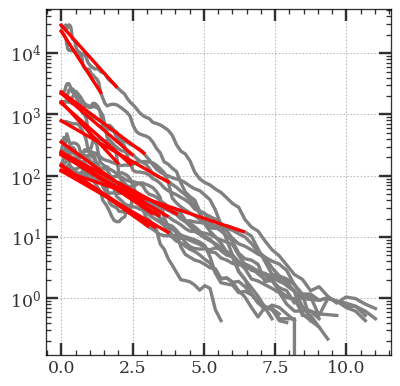

In [8]:
fig, ax = plot.subplots(1, figsize=4.5, margin=[0.1, 0.1, 0.1, 0.1], layout='none')

for i, (mb, z_form) in enumerate(zip(mbs, z_forms)):
    zs, m_hs = z_of_snaps[mb['SnapNum']], mb['M_Crit200']
    ax.c('grey').plot(zs, m_hs)
    
    # Draw a red tick connecting the formation point to the final.
    z_root = zs[0]
    m_h_root = m_hs[0]
    m_h_form = frac_m_h * m_h_root
    ax.c('r').plot([z_form, z_root], [m_h_form, m_h_root], zorder=10)
    
ax.scale(y='log')

For the whole chunk, we can loop over all trees, select all subhalos of interest, 
and evaluate their formation redshifts.

Here we plot their final halo mass versus formation redshift.

In [9]:
m_hs, z_forms = [], []
for tree_ind, tree in enumerate(trees):
    for h_ind, h in enumerate(tree):
        if h['FirstHaloInFOFgroup'] == h_ind \
            and h['SnapNum'] == snap \
            and h['M_Crit200'] >= 1.0e2:
            
            z_forms.append(find_z_form(tree, h_ind, frac_m_h))
            m_hs.append(h['M_Crit200'])
m_hs, z_forms = np.array(m_hs), np.array(z_forms)

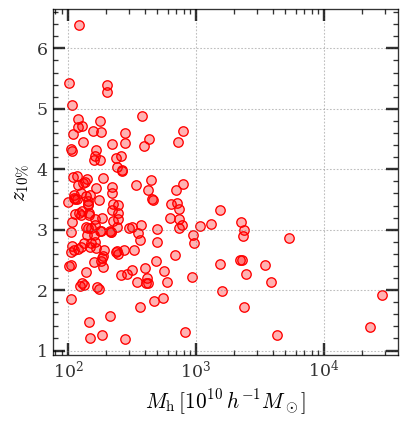

In [10]:
fig, ax = plot.subplots(1, figsize=4.5, margin=[0.1, 0.1, 0.1, 0.1], layout='none')

ax.c('r').scatter(m_hs, z_forms, s=50)\
    .scale(x='log').label(r'M_{\rm h}\,[10^{10}\,h^{-1}{M}_\odot]', 
                          r'z_{\rm 10\%}')